In [1]:
import os
import string
from collections import OrderedDict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable


cuda = True if torch.cuda.is_available() else False
print("Is cuda enabled?", "YES" if cuda else "NO")

Is cuda enabled? YES


In [2]:
REBUILD_DATA = False

IMG_SIZE = 32
FOLDER_PATH = "../../Data/Letters/"
CLASSES = list(string.ascii_lowercase)
LABEL_COUNT = len(CLASSES)
LABELS = dict(zip(CLASSES, np.arange(LABEL_COUNT)))

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


class DogsVSCats():
    classes_counts = dict(zip(CLASSES, np.zeros(LABEL_COUNT, dtype="int32")))
    training_X = []
    training_y = []
    
    def make_training_data(self):
        for label in LABELS:
            print(label, end=" ")
            for f in os.listdir(FOLDER_PATH + label):
                path = os.path.join(FOLDER_PATH + label, f)
                img = rgb2gray(plt.imread(path))
                self.training_X.append(img)
                self.training_y.append(np.eye(LABEL_COUNT)[LABELS[label]])
                self.classes_counts[label] += 1
        self.training_X = np.array(self.training_X)
        self.training_y = np.array(self.training_y)
        shuffled_order = np.random.default_rng().permutation(self.training_X.shape[0])
        np.save("training_images.npy", self.training_X[shuffled_order])
        np.save("training_labels.npy", self.training_y[shuffled_order])

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()
    print("\n", dogsvscats.classes_counts)

training_X = np.load("training_images.npy", allow_pickle=True)
training_y = np.load("training_labels.npy", allow_pickle=True)
print(f"\ntraining_data.shape = {training_X.shape}")


training_data.shape = (7436, 32, 32)


In [4]:
training_X[0], training_y[0]

(array([[254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
        [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
        [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
        ...,
        [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
        [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
        [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745]]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, 1, 2)
        
        self._out_dim = 128 * int(np.floor(IMG_SIZE / 2 ** 3) ** 2)
        # 128 - n-channels; IMG_SIZE - input dim; 2 - pool dim; 3 - k-pools; 2 - an image is like a square
        
        self.fc1 = nn.Linear(self._out_dim, 512)
        self.fc2 = nn.Linear(512, 26)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        
        x = x.view(-1, self._out_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [6]:
net = Net()
net._out_dim

2048

In [7]:
TEST_RATIO = 0.1

optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_function = nn.MSELoss()

training_X = training_X / 127.5 - 1
training_y = training_y
X = torch.Tensor(training_X).view(-1, IMG_SIZE, IMG_SIZE)
y = torch.Tensor(training_y)

test_size = int(len(X) * TEST_RATIO)
print(f"Test size: {test_size}")
print(f"Train size: {len(training_X) - test_size}")

Test size: 743
Train size: 6693


In [8]:
def split_data(in_data, part_size):
    return in_data[-part_size:], in_data[:-part_size]

In [9]:
test_X, train_X = split_data(X, test_size)
test_y, train_y = split_data(y, test_size)

print(f"len(train_X) = {len(train_X)}")
print(f"len(test_X) = {len(test_X)}")

len(train_X) = 6693
len(test_X) = 743


In [10]:
def validate(X, y):
    with torch.no_grad():
        real_class = torch.argmax(y, dim=1)
        net_out = net(X.view(X.shape[0], 1, IMG_SIZE, IMG_SIZE))
        predicted_class = torch.argmax(net_out, dim=1)
        acc = np.sum(predicted_class.numpy() == real_class.numpy()) / real_class.shape[0]
    return acc * 100

In [11]:
BATCH_SIZE = 60
VALIDATION_RATIO = 0.2
EPOCHS = 32

validation_size = int(len(X) * VALIDATION_RATIO)
loss_log = []
accuracy_log = []
stable_accuracy_log = []
for epoch in tqdm(range(EPOCHS)):
    shuffled_order = torch.randperm(len(train_X))
    validation_X, train_iter_X = split_data(train_X[shuffled_order], validation_size)
    validation_y, train_iter_y = split_data(train_y[shuffled_order], validation_size)
    
    for i in range(0, len(train_iter_X), BATCH_SIZE):
        batch_X = train_iter_X[i:i + BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE)
        batch_y = train_iter_y[i:i + BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
    loss_log.append(loss.item())
    accuracy_log.append(validate(validation_X, validation_y))  
    stable_accuracy_log.append(validate(test_X, test_y))  
    
        
print(f"Final loss: {loss.item()}")
print(f"Final accuracy: {validate(test_X, test_y):.2f}%")

  0%|                                                                                                   | 0/32 [00:00<?, ?it/s]/home/vitalii/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:43<00:00,  3.24s/it]

Final loss: 0.004698547068983316
Final accuracy: 86.94%


In [12]:
print(f"Final accuracy: {validate(test_X, test_y):.2f}%")

Final accuracy: 86.94%


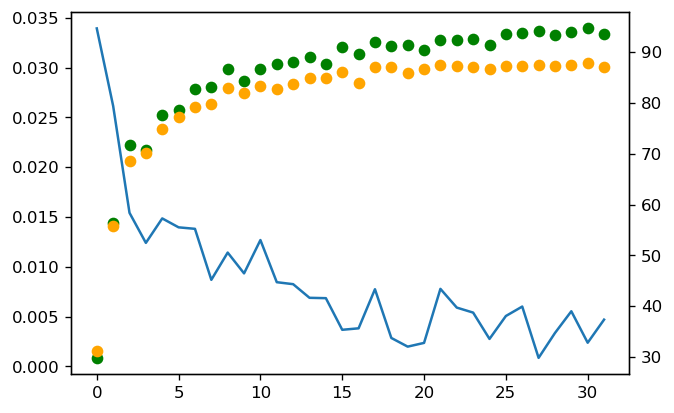

In [13]:
plt.rcParams['figure.dpi'] =  120

fig, ax = plt.subplots()

ax.plot(np.arange(len(loss_log)), loss_log)

ax2 = plt.twinx(ax)
ax2.scatter(np.arange(len(accuracy_log)), accuracy_log, 
            color="green")

ax2.scatter(np.arange(len(stable_accuracy_log)), stable_accuracy_log, 
           color="orange")


In [14]:
plt.savefig("training_v3.png")

<Figure size 720x480 with 0 Axes>

Predicted values:	 ['Q' 'W' 'P' 'G' 'Q' 'F' 'U' 'L' 'Q' 'Q' 'A' 'R' 'J' 'A' 'V' 'K' 'R' 'T' 'N' 'L']
Origingal values:	 ['Q' 'W' 'P' 'G' 'Q' 'F' 'U' 'L' 'Q' 'Q' 'A' 'R' 'J' 'A' 'V' 'K' 'R' 'T' 'N' 'L']


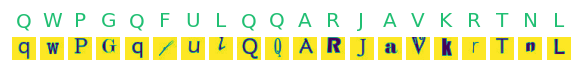

In [34]:
def show_examples(n_examples=20):
    rng = np.random.default_rng()
    ex_ind = rng.integers(low=0, high=training_X.shape[0], size=n_examples)
    
    example_X = torch.Tensor(training_X[ex_ind]).view(n_examples, 1, IMG_SIZE, IMG_SIZE)
    with torch.no_grad():
        net_out = net(example_X)
    
    predicted_letters = np.array([string.ascii_uppercase[j] for j in torch.argmax(net_out, dim=1)])
    real_letters = np.array([string.ascii_uppercase[j] for j in np.argmax(training_y[ex_ind], axis=1)])
    
    missed_indices = np.where(predicted_letters != real_letters)[0]
    
    fig, ax = plt.subplots(1,n_examples)
    for i, ind in enumerate(ex_ind):
        ax[i].imshow(training_X[ind])
        ax[i].axis("off")
        if i in missed_indices:
            ax[i].set_title(predicted_letters[i], c="#FD5E53")
        else:
            ax[i].set_title(predicted_letters[i], c="#21BF73")
            
    np.set_printoptions(linewidth=100)
    print(f"Predicted values:\t {predicted_letters}")
    print(f"Origingal values:\t {real_letters}")
    np.set_printoptions(linewidth=75)

    
show_examples()